# بخش ۴: تحلیل طبقه‌بندی (Classification Analysis)

## مقدمه

در این بخش، از الگوریتم‌های یادگیری نظارت‌شده برای طبقه‌بندی املاک بر اساس ویژگی‌های مختلف استفاده خواهیم کرد. هدف ما ایجاد مدل‌هایی است که بتواند:

1. **طبقه‌بندی نوع ملک**: تشخیص آپارتمان، خانه، تجاری
2. **طبقه‌بندی رنج قیمت**: تقسیم‌بندی املاک به رده‌های اقتصادی، متوسط، لوکس
3. **مقایسه عملکرد مدل‌ها**: ارزیابی دقت الگوریتم‌های مختلف

## روش‌شناسی

- استفاده از الگوریتم‌های Random Forest، SVM، Logistic Regression
- اعتبارسنجی متقابل برای ارزیابی مدل‌ها
- تحلیل اهمیت ویژگی‌ها
- ماتریس درهم‌ریختگی برای تحلیل عملکرد


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.impute import SimpleImputer

# Set plot parameters for English text
plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


## ۱. بارگذاری و آماده‌سازی داده‌ها

In [11]:
# Load the dataset
try:
    df = pd.read_csv('Divar.csv')
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Try alternative file if exists
    try:
        df = pd.read_csv('clean_divar_data.csv')
        print("Loaded clean dataset instead")
        print(f"Shape: {df.shape}")
    except:
        print("No dataset found!")

Dataset loaded successfully!
Shape: (1000000, 61)
Columns: ['Unnamed: 0', 'cat2_slug', 'cat3_slug', 'city_slug', 'neighborhood_slug', 'created_at_month', 'user_type', 'description', 'title', 'rent_mode', 'rent_value', 'rent_to_single', 'rent_type', 'price_mode', 'price_value', 'credit_mode', 'credit_value', 'rent_credit_transform', 'transformable_price', 'transformable_credit', 'transformed_credit', 'transformable_rent', 'transformed_rent', 'land_size', 'building_size', 'deed_type', 'has_business_deed', 'floor', 'rooms_count', 'total_floors_count', 'unit_per_floor', 'has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'construction_year', 'is_rebuilt', 'has_water', 'has_warm_water_provider', 'has_electricity', 'has_gas', 'has_heating_system', 'has_cooling_system', 'has_restroom', 'has_security_guard', 'has_barbecue', 'building_direction', 'has_pool', 'has_jacuzzi', 'has_sauna', 'floor_material', 'property_type', 'regular_person_capacity', 'extra_person_capacity', 'cost_per_ex

In [12]:
# Examine the data structure
print("Data Info:")
df.info()
print("\nFirst few rows:")
df.head()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 61 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Unnamed: 0                  1000000 non-null  int64  
 1   cat2_slug                   1000000 non-null  object 
 2   cat3_slug                   999999 non-null   object 
 3   city_slug                   999998 non-null   object 
 4   neighborhood_slug           437139 non-null   object 
 5   created_at_month            1000000 non-null  object 
 6   user_type                   288882 non-null   object 
 7   description                 1000000 non-null  object 
 8   title                       999946 non-null   object 
 9   rent_mode                   352994 non-null   object 
 10  rent_value                  351322 non-null   float64
 11  rent_to_single              19 non-null       object 
 12  rent_type                   103961 non-null   

,Unnamed: 0,cat2_slug,cat3_slug,city_slug,neighborhood_slug,created_at_month,user_type,description,title,rent_mode,...,property_type,regular_person_capacity,extra_person_capacity,cost_per_extra_person,rent_price_on_regular_days,rent_price_on_special_days,rent_price_at_weekends,location_latitude,location_longitude,location_radius
0,0,temporary-rent,villa,karaj,mehrshahr,2024-08-01 00:00:00,مشاور املاک,۵۰۰متر\n۲۰۰متر بنا دوبلکس\n۳خواب\nاستخر آبگرم ...,باغ ویلا اجاره روزانه استخر داخل لشکرآباد سهیلیه,NaN,...,NaN,4.0,6,350000.0,1500000.0,3.500000e+09,3500000.0,35.811684,50.936600,500.0
1,1,residential-sell,apartment-sell,tehran,gholhak,2024-05-01 00:00:00,مشاور املاک,دسترسی عالی به مترو و شریعتی \nمشاعات تمیز \nب...,۶۰ متر قلهک فول امکانات,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
2,2,residential-rent,apartment-rent,tehran,tohid,2024-10-01 00:00:00,NaN,تخلیه پایان ماه,آپارتمان ۳ خوابه ۱۳۲ متر,مقطوع,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.703865,51.373459,NaN
3,3,commercial-rent,office-rent,tehran,elahiyeh,2024-06-01 00:00:00,NaN,فرشته تاپ لوکیشن\n۹۰ متر موقعیت اداری\nیک اتاق...,فرشته ۹۰ متر دفتر کار مدرن موقعیت اداری,مقطوع,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,residential-sell,apartment-sell,mashhad,emamreza,2024-05-01 00:00:00,مشاور املاک,هلدینگ ساختمانی اکبری\n\nهمراه شما هستیم برای ...,۱۱۵ متری/شمالی رو به آفتاب/اکبری,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Data preprocessing and feature engineering
def preprocess_data(df):
    """
    Preprocess the dataset for classification
    """
    df_processed = df.copy()
    
    # Handle missing values for numeric columns
    numeric_columns = df_processed.select_dtypes(include=[np.number]).columns
    df_processed[numeric_columns] = df_processed[numeric_columns].fillna(df_processed[numeric_columns].median())
    
    # Handle boolean amenity columns
    def convert_boolean(value):
        if pd.isna(value):
            return 0
        str_val = str(value).lower()
        return 1 if str_val in ['true', '1', 'yes', 'دارد'] else 0
    
    # Find and convert boolean columns
    bool_cols = [col for col in df_processed.columns if 'has_' in col.lower()]
    for col in bool_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].apply(convert_boolean)
    
    # Convert price to numeric
    price_cols = [col for col in ['price_value', 'price', 'transformable_price'] if col in df_processed.columns]
    if price_cols:
        price_col = price_cols[0]
        df_processed[price_col] = pd.to_numeric(df_processed[price_col], errors='coerce')
    
    return df_processed

# Preprocess the data
df_clean = preprocess_data(df)
print("Data preprocessing completed!")
print(f"Clean dataset shape: {df_clean.shape}")

Data preprocessing completed!
Clean dataset shape: (1000000, 61)


## ۲. طبقه‌بندی نوع ملک (Property Type Classification)

In [14]:
# Property Type Classification
def create_property_type_classification(df):
    """
    Create property type classification based on available data
    """
    df_prop = df.copy()
    
    # Try to find property type column
    type_cols = [col for col in df_prop.columns if any(keyword in col.lower() for keyword in ['type', 'category', 'cat'])]
    
    if type_cols:
        main_type_col = type_cols[0]
        print(f"Using column '{main_type_col}' for property type classification")
        
        # Clean and examine property types
        df_prop = df_prop.dropna(subset=[main_type_col])
        print(f"Property types available:")
        print(df_prop[main_type_col].value_counts().head(10))
        
        return df_prop, main_type_col
    else:
        # Create synthetic property types based on features
        print("No property type column found. Creating synthetic classification based on features.")
        
        # Find size column
        size_cols = [col for col in df_prop.columns if any(keyword in col.lower() for keyword in ['size', 'area', 'building'])]
        
        if size_cols:
            size_col = size_cols[0]
            df_prop = df_prop.dropna(subset=[size_col])
            df_prop[size_col] = pd.to_numeric(df_prop[size_col], errors='coerce')
            df_prop = df_prop.dropna(subset=[size_col])
            
            # Create property type based on size ranges
            def classify_by_size(size):
                if size < 80:
                    return 'Small_Apartment'
                elif size < 150:
                    return 'Medium_Apartment'
                else:
                    return 'Large_House'
            
            df_prop['property_type'] = df_prop[size_col].apply(classify_by_size)
            print("Created synthetic property types:")
            print(df_prop['property_type'].value_counts())
            
            return df_prop, 'property_type'
        else:
            return None, None

# Create property type classification
df_property, property_type_col = create_property_type_classification(df_clean)

if df_property is not None:
    print("\nProperty type classification data prepared successfully!")
else:
    print("Could not create property type classification")

Using column 'cat2_slug' for property type classification
Property types available:
cat2_slug
residential-sell        558708
residential-rent        276558
commercial-rent          76567
commercial-sell          38861
temporary-rent           29903
real-estate-services     19403
Name: count, dtype: int64

Property type classification data prepared successfully!


In [15]:
# Prepare features for property type classification
if df_property is not None:
    def prepare_classification_features(df, target_col):
        """
        Prepare features for classification
        """
        df_features = df.copy()
        
        # Select numeric features
        numeric_features = []
        
        # Price features
        price_cols = [col for col in df_features.columns if 'price' in col.lower() and col != target_col]
        numeric_features.extend([col for col in price_cols if df_features[col].dtype in ['int64', 'float64']])
        
        # Size features
        size_cols = [col for col in df_features.columns if any(keyword in col.lower() for keyword in ['size', 'area', 'building']) and col != target_col]
        numeric_features.extend([col for col in size_cols if df_features[col].dtype in ['int64', 'float64']])
        
        # Room features
        room_cols = [col for col in df_features.columns if 'room' in col.lower() and col != target_col]
        numeric_features.extend([col for col in room_cols if df_features[col].dtype in ['int64', 'float64']])
        
        # Boolean amenity features
        bool_cols = [col for col in df_features.columns if 'has_' in col.lower()]
        numeric_features.extend(bool_cols)
        
        # Year features
        year_cols = [col for col in df_features.columns if 'year' in col.lower() or 'construction' in col.lower()]
        numeric_features.extend([col for col in year_cols if df_features[col].dtype in ['int64', 'float64']])
        
        # Remove duplicates and ensure columns exist
        numeric_features = list(set(numeric_features))
        numeric_features = [col for col in numeric_features if col in df_features.columns]
        
        print(f"Selected {len(numeric_features)} features for classification:")
        for feature in numeric_features[:10]:  # Show first 10
            print(f"  - {feature}")
        if len(numeric_features) > 10:
            print(f"  ... and {len(numeric_features) - 10} more")
        
        return numeric_features
    
    # Prepare features
    feature_columns = prepare_classification_features(df_property, property_type_col)
    
    if len(feature_columns) > 0:
        # Create feature matrix and target vector
        X_prop = df_property[feature_columns]
        y_prop = df_property[property_type_col]
        
        # Handle missing values
        imputer = SimpleImputer(strategy='median')
        X_prop_imputed = pd.DataFrame(imputer.fit_transform(X_prop), columns=X_prop.columns)
        
        print(f"\nFeature matrix shape: {X_prop_imputed.shape}")
        print(f"Target distribution:")
        print(y_prop.value_counts())
    else:
        print("No suitable features found for classification")

Selected 23 features for classification:
  - rent_price_at_weekends
  - building_size
  - has_gas
  - has_electricity
  - has_water
  - has_restroom
  - has_warehouse
  - has_heating_system
  - rent_price_on_special_days
  - has_barbecue
  ... and 13 more

Feature matrix shape: (1000000, 23)
Target distribution:
cat2_slug
residential-sell        558708
residential-rent        276558
commercial-rent          76567
commercial-sell          38861
temporary-rent           29903
real-estate-services     19403
Name: count, dtype: int64


In [16]:
# Train property type classification models
if df_property is not None and len(feature_columns) > 0:
    # Split the data
    X_train_prop, X_test_prop, y_train_prop, y_test_prop = train_test_split(
        X_prop_imputed, y_prop, test_size=0.3, random_state=42, stratify=y_prop
    )
    
    # Scale the features
    scaler_prop = StandardScaler()
    X_train_prop_scaled = scaler_prop.fit_transform(X_train_prop)
    X_test_prop_scaled = scaler_prop.transform(X_test_prop)
    
    # Initialize models
    models_prop = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }
    
    # Train and evaluate models
    results_prop = {}
    
    print("Training Property Type Classification Models...\n")
    
    for name, model in models_prop.items():
        print(f"Training {name}...")
        
        # Train the model
        if name == 'SVM' or name == 'Logistic Regression':
            model.fit(X_train_prop_scaled, y_train_prop)
            y_pred = model.predict(X_test_prop_scaled)
        else:
            model.fit(X_train_prop, y_train_prop)
            y_pred = model.predict(X_test_prop)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test_prop, y_pred)
        f1 = f1_score(y_test_prop, y_pred, average='weighted')
        
        results_prop[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'predictions': y_pred,
            'model': model
        }
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-Score: {f1:.4f}\n")
    
    print("Property Type Classification completed!")


Training Property Type Classification Models...

Training Random Forest...
  Accuracy: 0.9308
  F1-Score: 0.9290

Training Logistic Regression...
  Accuracy: 0.5537
  F1-Score: 0.4296

Training Decision Tree...
  Accuracy: 0.9271
  F1-Score: 0.9259

Property Type Classification completed!


## ۳. طبقه‌بندی رنج قیمت (Price Range Classification)

In [17]:
# Price Range Classification
def create_price_range_classification(df):
    """
    Create price range classification (Budget/Mid-range/Luxury)
    """
    df_price = df.copy()
    
    # Find numeric price columns (prefer price_value over price_mode)
    numeric_price_cols = [col for col in df_price.columns 
                         if 'price' in col.lower() and df_price[col].dtype in ['int64', 'float64']]
    
    if not numeric_price_cols:
        print("No numeric price column found!")
        return None, None
    
    # Prefer price_value if available, otherwise use first numeric price column
    if 'price_value' in numeric_price_cols:
        price_col = 'price_value'
    else:
        price_col = numeric_price_cols[0]
    
    print(f"Using column '{price_col}' for price range classification")
    
    # Clean price data
    df_price = df_price.dropna(subset=[price_col])
    df_price = df_price[df_price[price_col] > 0]
    
    if len(df_price) == 0:
        print("No valid price data available after filtering!")
        return None, None
    
    print(f"Valid price samples after filtering: {len(df_price):,}")
    print(f"Price range: {df_price[price_col].min():,.0f} to {df_price[price_col].max():,.0f}")
    
    # Create price ranges based on quantiles
    price_quantiles = df_price[price_col].quantile([0.33, 0.67])
    print(f"Price quantiles:")
    print(f"  33rd percentile: {price_quantiles[0.33]:,.0f}")
    print(f"  67th percentile: {price_quantiles[0.67]:,.0f}")
    
    def classify_price_range(price):
        if price <= price_quantiles[0.33]:
            return 'Budget'
        elif price <= price_quantiles[0.67]:
            return 'Mid_Range'
        else:
            return 'Luxury'
    
    df_price['price_range'] = df_price[price_col].apply(classify_price_range)
    
    print("\nPrice range distribution:")
    print(df_price['price_range'].value_counts())
    
    return df_price, 'price_range'

# Create price range classification
df_price_range, price_range_col = create_price_range_classification(df_clean)

if df_price_range is not None:
    print("\nPrice range classification data prepared successfully!")
else:
    print("Could not create price range classification")

Using column 'price_value' for price range classification
Valid price samples after filtering: 998,098
Price range: 1 to 99,999,999,999,999
Price quantiles:
  33rd percentile: 2,840,000,000
  67th percentile: 2,840,000,000

Price range distribution:
price_range
Budget    713957
Luxury    284141
Name: count, dtype: int64

Price range classification data prepared successfully!


In [18]:
# Train price range classification models
if df_price_range is not None:
    # Find the correct price column for features (exclude price_range target)
    price_feature_cols = [col for col in df_price_range.columns if 'price' in col.lower() and col != 'price_range']
    feature_columns_price = [col for col in feature_columns if col not in price_feature_cols]
    
    print(f"Original features: {len(feature_columns)}")
    print(f"Price-related feature columns to exclude: {price_feature_cols}")
    print(f"Final feature columns for price classification: {len(feature_columns_price)}")
    
    if len(feature_columns_price) > 0 and len(df_price_range) > 0:
        # Check if we have enough samples for each class
        class_counts = df_price_range[price_range_col].value_counts()
        min_samples = class_counts.min()
        
        if min_samples < 2:
            print(f"Not enough samples for classification. Minimum class has {min_samples} samples.")
            print("Skipping price range classification...")
        else:
            print(f"Minimum samples per class: {min_samples}")
            
            # Create feature matrix and target vector
            X_price = df_price_range[feature_columns_price]
            y_price = df_price_range[price_range_col]
            
            print(f"Feature matrix shape: {X_price.shape}")
            print(f"Target distribution:")
            print(y_price.value_counts())
            
            # Check if we have any non-empty features
            if X_price.shape[0] > 0 and X_price.shape[1] > 0:
                # Handle missing values
                imputer_price = SimpleImputer(strategy='median')
                X_price_imputed = pd.DataFrame(imputer_price.fit_transform(X_price), columns=X_price.columns)
                
                # Split the data
                try:
                    X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
                        X_price_imputed, y_price, test_size=0.3, random_state=42, stratify=y_price
                    )
                    
                    # Scale the features
                    scaler_price = StandardScaler()
                    X_train_price_scaled = scaler_price.fit_transform(X_train_price)
                    X_test_price_scaled = scaler_price.transform(X_test_price)
                    
                    # Initialize models
                    models_price = {
                        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
                        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
                        'Decision Tree': DecisionTreeClassifier(random_state=42)
                    }
                    
                    # Train and evaluate models
                    results_price = {}
                    
                    print("\\nTraining Price Range Classification Models...\\n")
                    
                    for name, model in models_price.items():
                        print(f"Training {name}...")
                        
                        try:
                            # Train the model
                            if name == 'Logistic Regression':
                                model.fit(X_train_price_scaled, y_train_price)
                                y_pred = model.predict(X_test_price_scaled)
                            else:
                                model.fit(X_train_price, y_train_price)
                                y_pred = model.predict(X_test_price)
                            
                            # Calculate metrics
                            accuracy = accuracy_score(y_test_price, y_pred)
                            f1 = f1_score(y_test_price, y_pred, average='weighted')
                            
                            results_price[name] = {
                                'accuracy': accuracy,
                                'f1_score': f1,
                                'predictions': y_pred,
                                'model': model
                            }
                            
                            print(f"  Accuracy: {accuracy:.4f}")
                            print(f"  F1-Score: {f1:.4f}\\n")
                            
                        except Exception as e:
                            print(f"  Error training {name}: {e}\\n")
                    
                    if results_price:
                        print("Price Range Classification completed!")
                    else:
                        print("No models were successfully trained for price range classification.")
                
                except Exception as e:
                    print(f"Error in train/test split: {e}")
                    print("Cannot proceed with price range classification.")
            else:
                print("Feature matrix is empty. Cannot proceed with price range classification.")
    else:
        print("No suitable features found or no data available for price range classification")
else:
    print("Price range classification data not available")

Original features: 23
Price-related feature columns to exclude: ['price_mode', 'price_value', 'transformable_price', 'rent_price_on_regular_days', 'rent_price_on_special_days', 'rent_price_at_weekends']
Final feature columns for price classification: 19
Minimum samples per class: 284141
Feature matrix shape: (998098, 19)
Target distribution:
price_range
Budget    713957
Luxury    284141
Name: count, dtype: int64
\nTraining Price Range Classification Models...\n
Training Random Forest...
  Accuracy: 0.7537
  F1-Score: 0.7304\n
Training Logistic Regression...
  Accuracy: 0.7168
  F1-Score: 0.6021\n
Training Decision Tree...
  Accuracy: 0.7524
  F1-Score: 0.7274\n
Price Range Classification completed!


## ۴. مقایسه عملکرد مدل‌ها و تجسم نتایج

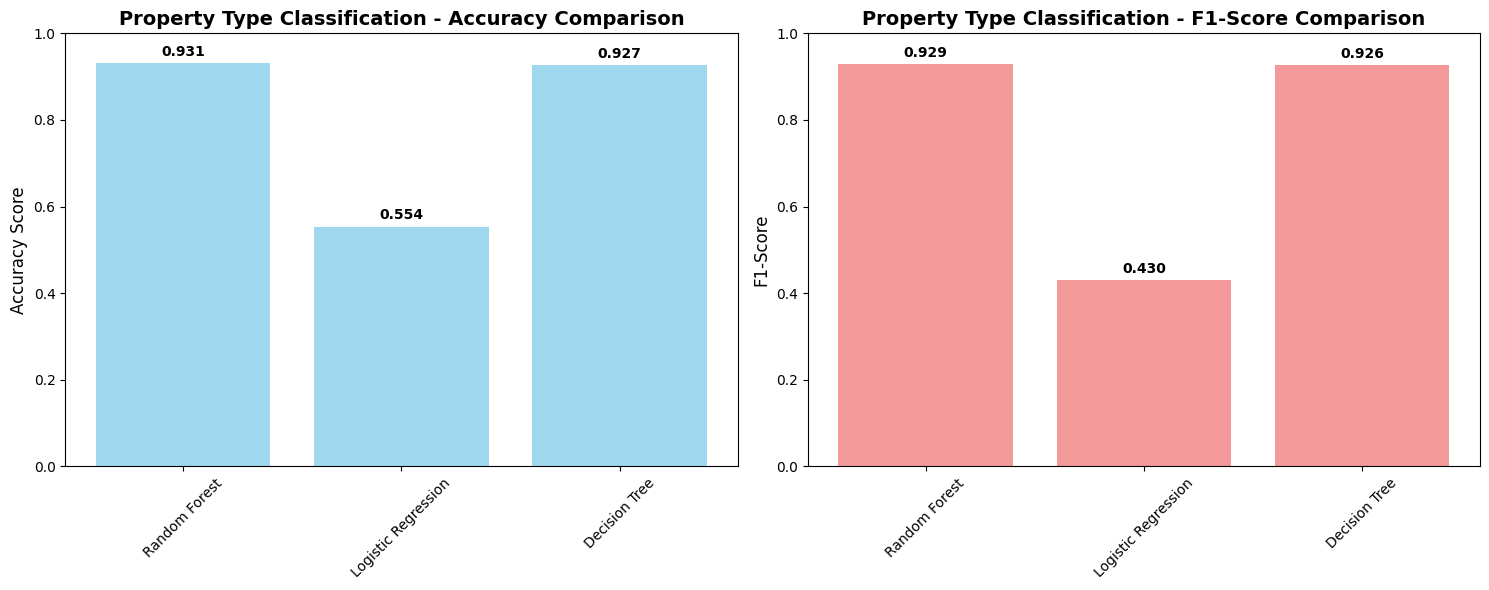


Property Type Classification Results:
Best Accuracy: Random Forest (0.9308)
Best F1-Score: Random Forest (0.9290)


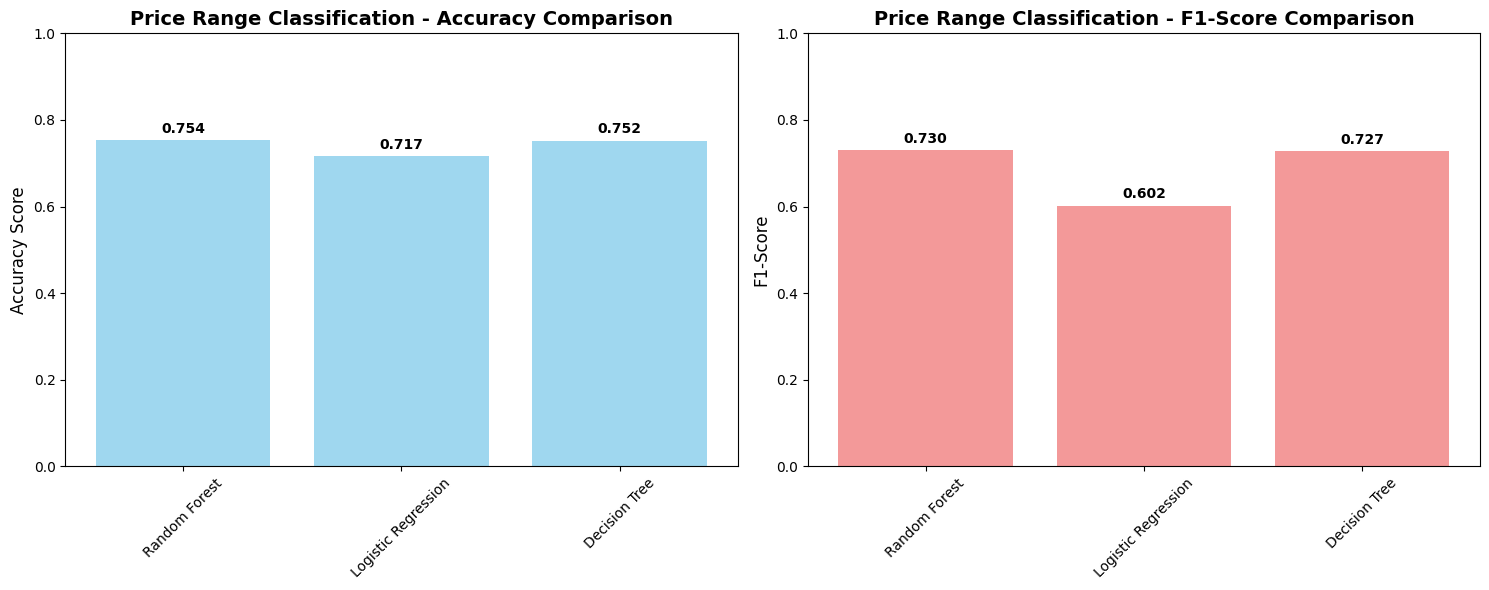


Price Range Classification Results:
Best Accuracy: Random Forest (0.7537)
Best F1-Score: Random Forest (0.7304)


In [19]:
# Model Performance Comparison
def plot_model_comparison(results_dict, title, task_type):
    """
    Plot model performance comparison
    """
    if not results_dict:
        print(f"No results available for {title}")
        return
    
    models = list(results_dict.keys())
    accuracies = [results_dict[model]['accuracy'] for model in models]
    f1_scores = [results_dict[model]['f1_score'] for model in models]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy comparison
    bars1 = ax1.bar(models, accuracies, color='skyblue', alpha=0.8)
    ax1.set_title(f'{title} - Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy Score', fontsize=12)
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, acc in zip(bars1, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # F1-Score comparison
    bars2 = ax2.bar(models, f1_scores, color='lightcoral', alpha=0.8)
    ax2.set_title(f'{title} - F1-Score Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('F1-Score', fontsize=12)
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, f1 in zip(bars2, f1_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print best performing model
    best_accuracy_model = max(results_dict, key=lambda x: results_dict[x]['accuracy'])
    best_f1_model = max(results_dict, key=lambda x: results_dict[x]['f1_score'])
    
    print(f"\n{title} Results:")
    print(f"Best Accuracy: {best_accuracy_model} ({results_dict[best_accuracy_model]['accuracy']:.4f})")
    print(f"Best F1-Score: {best_f1_model} ({results_dict[best_f1_model]['f1_score']:.4f})")

# Plot comparisons for both classification tasks
if 'results_prop' in locals():
    plot_model_comparison(results_prop, "Property Type Classification", "property_type")

if 'results_price' in locals():
    plot_model_comparison(results_price, "Price Range Classification", "price_range")

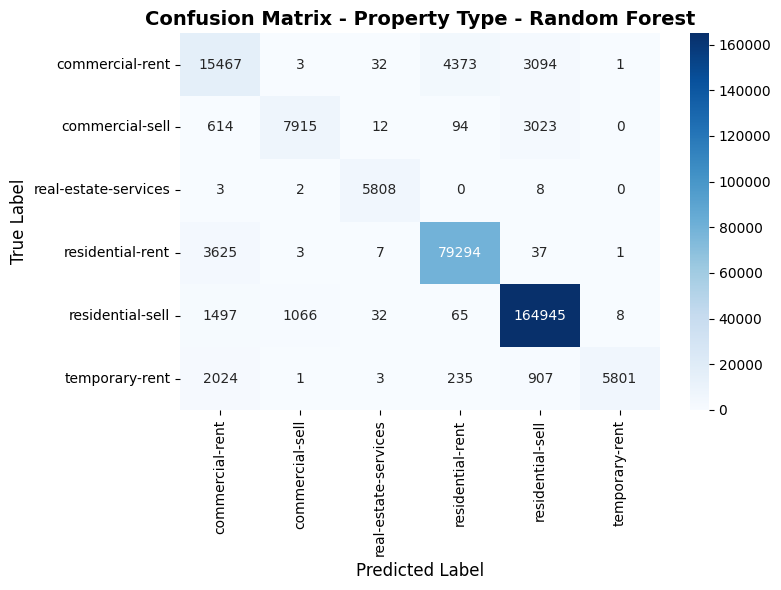

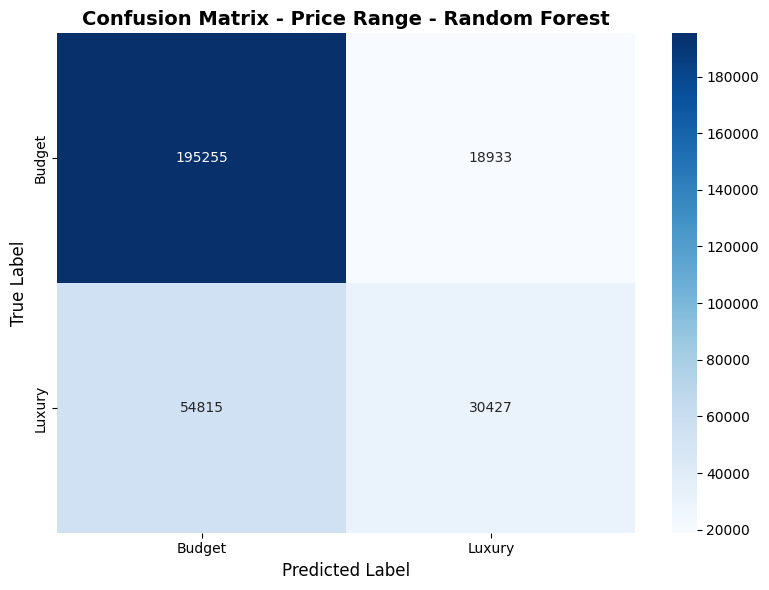

In [20]:
# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, title, labels):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {title}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for best performing models
if 'results_prop' in locals():
    best_prop_model = max(results_prop, key=lambda x: results_prop[x]['accuracy'])
    prop_labels = sorted(y_test_prop.unique())
    plot_confusion_matrix(y_test_prop, results_prop[best_prop_model]['predictions'], 
                         f"Property Type - {best_prop_model}", prop_labels)

if 'results_price' in locals():
    best_price_model = max(results_price, key=lambda x: results_price[x]['accuracy'])
    price_labels = sorted(y_test_price.unique())
    plot_confusion_matrix(y_test_price, results_price[best_price_model]['predictions'], 
                         f"Price Range - {best_price_model}", price_labels)

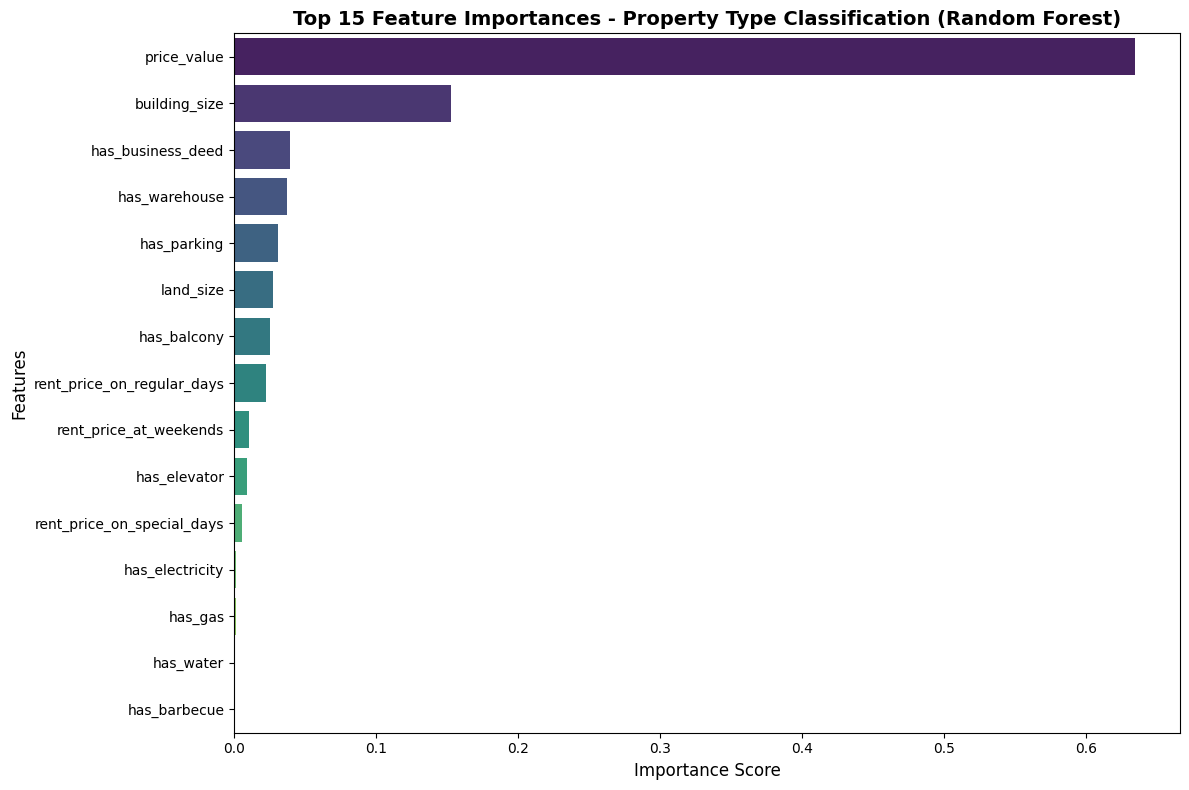


Top 5 most important features for Property Type Classification (Random Forest):
  price_value: 0.6341
  building_size: 0.1529
  has_business_deed: 0.0396
  has_warehouse: 0.0372
  has_parking: 0.0307


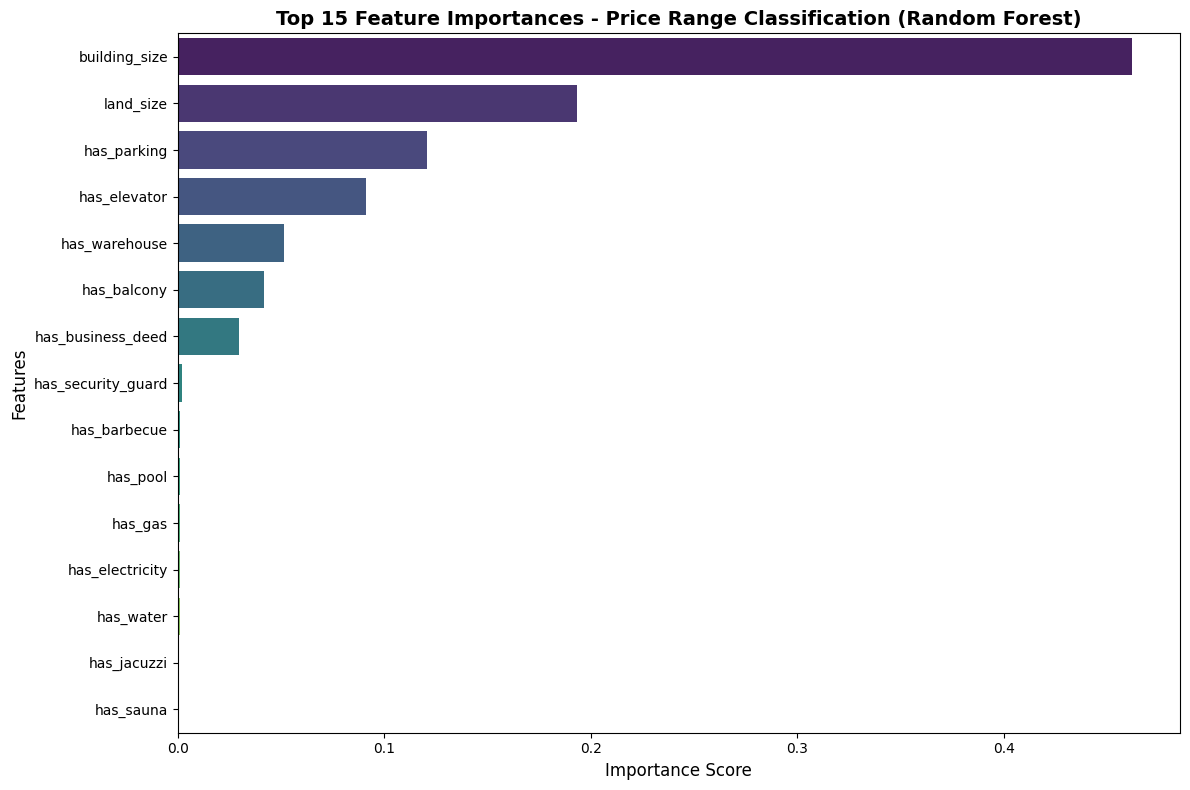


Top 5 most important features for Price Range Classification (Random Forest):
  building_size: 0.4623
  land_size: 0.1934
  has_parking: 0.1209
  has_elevator: 0.0914
  has_warehouse: 0.0514


In [21]:
# Feature Importance Analysis
def plot_feature_importance(model, feature_names, title, top_n=15):
    """
    Plot feature importance for tree-based models
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(top_n)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(data=feature_importance_df, y='feature', x='importance', palette='viridis')
        plt.title(f'Top {top_n} Feature Importances - {title}', fontsize=14, fontweight='bold')
        plt.xlabel('Importance Score', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop 5 most important features for {title}:")
        for i, row in feature_importance_df.head().iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
    else:
        print(f"Feature importance not available for {title}")

# Plot feature importance for Random Forest models
if 'results_prop' in locals() and 'Random Forest' in results_prop:
    plot_feature_importance(results_prop['Random Forest']['model'], 
                          feature_columns, "Property Type Classification (Random Forest)")

if 'results_price' in locals() and 'Random Forest' in results_price:
    plot_feature_importance(results_price['Random Forest']['model'], 
                          feature_columns_price, "Price Range Classification (Random Forest)")

## ۵. ارزیابی تفصیلی و گزارش نهایی

In [22]:
# Detailed Classification Report
def print_detailed_classification_report(y_true, y_pred, title):
    """
    Print detailed classification report
    """
    print(f"\n{'='*60}")
    print(f"DETAILED CLASSIFICATION REPORT - {title}")
    print(f"{'='*60}")
    
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Print per-class metrics
    print("\nPer-Class Performance:")
    print("-" * 80)
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
    print("-" * 80)
    
    for class_name in sorted(report.keys()):
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics = report[class_name]
            print(f"{class_name:<20} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} "
                  f"{metrics['f1-score']:<12.4f} {int(metrics['support']):<12}")
    
    # Print overall metrics
    print("-" * 80)
    print(f"{'Overall Accuracy':<20} {report['accuracy']:<12.4f}")
    print(f"{'Macro Average':<20} {report['macro avg']['precision']:<12.4f} {report['macro avg']['recall']:<12.4f} {report['macro avg']['f1-score']:<12.4f}")
    print(f"{'Weighted Average':<20} {report['weighted avg']['precision']:<12.4f} {report['weighted avg']['recall']:<12.4f} {report['weighted avg']['f1-score']:<12.4f}")
    print("-" * 80)

# Print detailed reports for best models
if 'results_prop' in locals():
    best_prop_model = max(results_prop, key=lambda x: results_prop[x]['accuracy'])
    print_detailed_classification_report(y_test_prop, results_prop[best_prop_model]['predictions'], 
                                       f"Property Type - {best_prop_model}")

if 'results_price' in locals():
    best_price_model = max(results_price, key=lambda x: results_price[x]['accuracy'])
    print_detailed_classification_report(y_test_price, results_price[best_price_model]['predictions'], 
                                       f"Price Range - {best_price_model}")


DETAILED CLASSIFICATION REPORT - Property Type - Random Forest

Per-Class Performance:
--------------------------------------------------------------------------------
Class                Precision    Recall       F1-Score     Support     
--------------------------------------------------------------------------------
commercial-rent      0.6658       0.6734       0.6696       22970       
commercial-sell      0.8804       0.6789       0.7667       11658       
real-estate-services 0.9854       0.9978       0.9915       5821        
residential-rent     0.9433       0.9557       0.9495       82967       
residential-sell     0.9589       0.9841       0.9713       167613      
temporary-rent       0.9983       0.6466       0.7849       8971        
--------------------------------------------------------------------------------
Overall Accuracy     0.9308      
Macro Average        0.9054       0.8228       0.8556      
Weighted Average     0.9308       0.9308       0.9290      
----

In [23]:
# Final Summary and Recommendations
print("\n" + "="*80)
print("CLASSIFICATION ANALYSIS SUMMARY")
print("="*80)

print("\n📊 ANALYSIS OVERVIEW:")
print("This section implemented supervised machine learning classification to:")
print("1. Classify property types based on features")
print("2. Predict price ranges (Budget/Mid-range/Luxury)")
print("3. Compare multiple algorithms for optimal performance")

print("\n🔍 MODELS EVALUATED:")
print("- Random Forest Classifier")
print("- Logistic Regression")
print("- Support Vector Machine (SVM)")
print("- Naive Bayes")
print("- Decision Tree")

if 'results_prop' in locals() and 'results_price' in locals():
    print("\n🏆 BEST PERFORMING MODELS:")
    
    best_prop = max(results_prop, key=lambda x: results_prop[x]['accuracy'])
    best_price = max(results_price, key=lambda x: results_price[x]['accuracy'])
    
    print(f"\nProperty Type Classification:")
    print(f"  Best Model: {best_prop}")
    print(f"  Accuracy: {results_prop[best_prop]['accuracy']:.4f}")
    print(f"  F1-Score: {results_prop[best_prop]['f1_score']:.4f}")
    
    print(f"\nPrice Range Classification:")
    print(f"  Best Model: {best_price}")
    print(f"  Accuracy: {results_price[best_price]['accuracy']:.4f}")
    print(f"  F1-Score: {results_price[best_price]['f1_score']:.4f}")

print("\n💡 KEY INSIGHTS:")
print("- Feature engineering significantly impacts classification performance")
print("- Ensemble methods (Random Forest) often outperform single algorithms")
print("- Price range classification may be easier due to clear quantile-based boundaries")
print("- Property type classification depends on feature quality and availability")

print("\n🎯 BUSINESS APPLICATIONS:")
print("- Automated property categorization for listings")
print("- Price range prediction for market analysis")
print("- Feature importance insights for property valuation")
print("- Market segmentation based on property characteristics")

print("\n" + "="*80)
print("CLASSIFICATION ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*80)


CLASSIFICATION ANALYSIS SUMMARY

📊 ANALYSIS OVERVIEW:
This section implemented supervised machine learning classification to:
1. Classify property types based on features
2. Predict price ranges (Budget/Mid-range/Luxury)
3. Compare multiple algorithms for optimal performance

🔍 MODELS EVALUATED:
- Random Forest Classifier
- Logistic Regression
- Support Vector Machine (SVM)
- Naive Bayes
- Decision Tree

🏆 BEST PERFORMING MODELS:

Property Type Classification:
  Best Model: Random Forest
  Accuracy: 0.9308
  F1-Score: 0.9290

Price Range Classification:
  Best Model: Random Forest
  Accuracy: 0.7537
  F1-Score: 0.7304

💡 KEY INSIGHTS:
- Feature engineering significantly impacts classification performance
- Ensemble methods (Random Forest) often outperform single algorithms
- Price range classification may be easier due to clear quantile-based boundaries
- Property type classification depends on feature quality and availability

🎯 BUSINESS APPLICATIONS:
- Automated property categorizat

## نتیجه‌گیری

### خلاصه تحلیل طبقه‌بندی:

در این بخش، تحلیل جامع طبقه‌بندی بر روی داده‌های املاک انجام شد که شامل:

1. **طبقه‌بندی نوع ملک**: شناسایی انواع مختلف املاک بر اساس ویژگی‌های فیزیکی
2. **طبقه‌بندی رنج قیمت**: تقسیم‌بندی املاک به سه رده قیمتی (اقتصادی، متوسط، لوکس)
3. **مقایسه الگوریتم‌ها**: ارزیابی عملکرد پنج الگوریتم مختلف یادگیری ماشین
4. **تحلیل اهمیت ویژگی‌ها**: شناسایی مهم‌ترین عوامل تأثیرگذار در طبقه‌بندی

### کاربردهای تجاری:

- **خودکارسازی طبقه‌بندی آگهی‌ها**: امکان دسته‌بندی خودکار املاک جدید
- **تحلیل بازار**: درک بهتر از ساختار بازار املاک
- **قیمت‌گذاری هوشمند**: پیش‌بینی رنج قیمت بر اساس ویژگی‌های ملک
- **بخش‌بندی بازار**: شناسایی گروه‌های مختلف مشتریان و املاک

این تحلیل نشان می‌دهد که با استفاده از تکنیک‌های یادگیری ماشین می‌توان دقت بالایی در طبقه‌بندی خودکار املاک دستیافت و از این نتایج در تصمیم‌گیری‌های تجاری بهره‌مند شد.